In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl


In [34]:
!pip install transformers datasets peft accelerate bitsandbytes


In [35]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, get_linear_schedule_with_warmup, AutoModel, AutoConfig
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [37]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [38]:
# Load the AG News dataset
agnews = load_dataset("ag_news")
print(f"Dataset loaded: {agnews}")

Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [39]:
# Display some examples from the training set
print("\nExample data:")
for i in range(3):
    print(f"Text: {agnews['train'][i]['text']}")
    print(f"Label: {agnews['train'][i]['label']}")
    print("-" * 50)


Example data:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: 2
--------------------------------------------------
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Label: 2
--------------------------------------------------
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Label: 2
--------------------------------------------------


In [40]:
# Define the class names for AG News
class_names = ["World", "Sports", "Business", "Sci/Tech"]


In [41]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Set max sequence length
MAX_LENGTH = 128

In [42]:
# Create a dataset class for AG News
class AGNewsDataset(Dataset):
    def __init__(self, split="train", max_length=MAX_LENGTH):
        self.data = agnews[split]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Remove the batch dimension
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }


In [43]:
# Create train and validation datasets
train_dataset = AGNewsDataset(split="train")
test_dataset = AGNewsDataset(split="test")



In [44]:
# Create data loaders
BATCH_SIZE = 64  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [45]:
class RobertaClassifier(nn.Module):
    def __init__(self, model_name="roberta-base", num_classes=4):
        super(RobertaClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.roberta = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        **kwargs
    ):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            **kwargs
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [46]:
# Initialize the model
model = RobertaClassifier(num_classes=4)

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,  # Rank of the update matrices
    lora_alpha=32,  # Alpha parameter for LoRA scaling
    lora_dropout=0.1,  # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"],  # Apply LoRA to attention layers only
)
model = get_peft_model(model, lora_config)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# Print trainable parameters
model.print_trainable_parameters()


trainable params: 1,772,548 || all params: 126,421,256 || trainable%: 1.4021


In [48]:
# Move model to device
model = model.to(device)

In [49]:
# Define optimizer and loss function
LEARNING_RATE = 3e-5  # Slightly higher learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)  # Weight decay added

In [50]:
# Calculate number of training steps
num_epochs = 5  # Increased number of epochs
num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.05 * num_training_steps)  # Slightly lower warmup ratio



In [51]:

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


In [52]:
# Gradient clipping to avoid exploding gradients
max_grad_norm = 1.0  # Gradient clipping value


In [53]:
# Training function with gradient clipping
def train(model, dataloader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()

        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        progress_bar.set_postfix({
            "loss": total_loss / (progress_bar.n + 1),
            "accuracy": total_correct / total_samples
        })

    return total_loss / len(dataloader), total_correct / total_samples


In [54]:
# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy


In [55]:
# Training loop with increased epochs
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs=3
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-" * 50)


Epoch 1/3


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Train Loss: 0.6946, Train Accuracy: 0.8058
Test Loss: 0.5223, Test Accuracy: 0.9167
--------------------------------------------------
Epoch 2/3


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Train Loss: 0.5197, Train Accuracy: 0.9178
Test Loss: 0.5097, Test Accuracy: 0.9241
--------------------------------------------------
Epoch 3/3


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Train Loss: 0.5081, Train Accuracy: 0.9228
Test Loss: 0.4995, Test Accuracy: 0.9288
--------------------------------------------------


In [56]:
def predict_class(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(logits, dim=1).item()

    return class_names[pred]

Total number of trainable parameters: 1772548


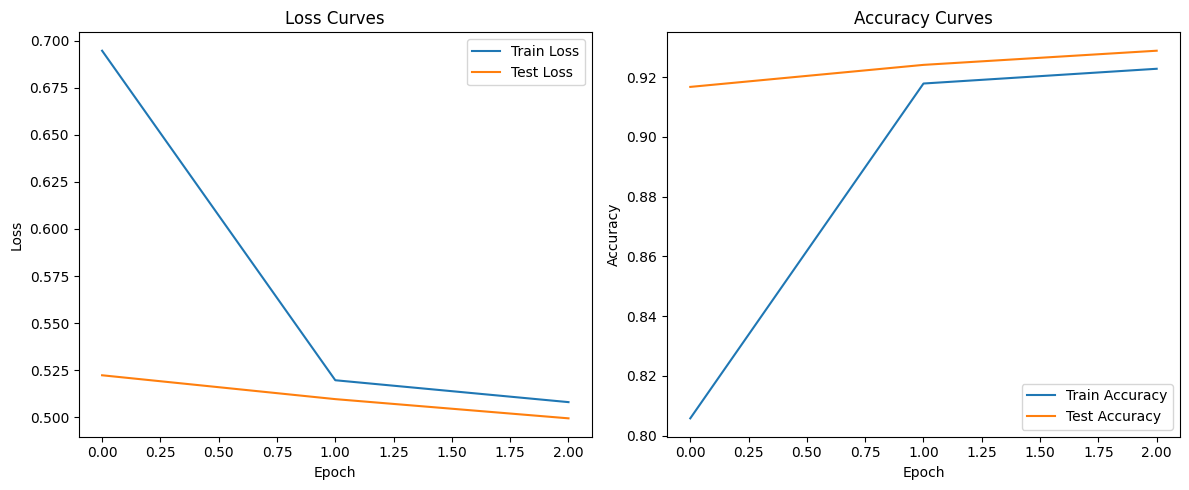


Predictions on sample texts:
Text: Oil prices hit a record high as tensions rise in the Middle East.
Predicted class: Business

Text: Manchester United wins 3-0 against Liverpool in Premier League clash.
Predicted class: Sports

Text: Apple announces new iPhone with revolutionary features at annual event.
Predicted class: Sci/Tech

Text: Scientists discover breakthrough in quantum computing research.
Predicted class: Sci/Tech

Model saved to roberta_lora_agnews

Training Summary:
Total Number of Trainable Parameters: 1772548

Predictions on sample texts:
Text: Oil prices hit a record high as tensions rise in the Middle East.
Predicted class: Business (Confidence: 0.8497)
---
Text: Manchester United wins 3-0 against Liverpool in Premier League clash.
Predicted class: Sports (Confidence: 0.8285)
---
Text: Apple announces new iPhone with revolutionary features at annual event.
Predicted class: Sci/Tech (Confidence: 0.8780)
---
Text: Scientists discover breakthrough in quantum computing r

Predicting:   0%|          | 0/8000 [00:00<?, ?it/s]

Submission file saved to improved_submission.csv


In [57]:
import pickle

# Get and print the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_trainable_params = count_parameters(model)
print(f"Total number of trainable parameters: {total_trainable_params}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.savefig("training_history.png")
plt.show()

# Test on a few examples
test_examples = [
    "Oil prices hit a record high as tensions rise in the Middle East.",
    "Manchester United wins 3-0 against Liverpool in Premier League clash.",
    "Apple announces new iPhone with revolutionary features at annual event.",
    "Scientists discover breakthrough in quantum computing research."
]



print("\nPredictions on sample texts:")
for text in test_examples:
    predicted_class = predict_class(text, model, tokenizer, device)
    print(f"Text: {text}\nPredicted class: {predicted_class}\n")

# Save model to specified output directory
output_dir = "roberta_lora_agnews"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

# Print final summary
print("\nTraining Summary:")
# print(f"Final Test Accuracy: {test_accuracies:.4f}")
print(f"Total Number of Trainable Parameters: {total_trainable_params}")

# Verify parameters are under 10M
assert total_trainable_params < 10 * 10**6, f"Too many parameters: {total_trainable_params}"

# Function for prediction
def predict_class(text, model, tokenizer, device):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run the model to get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Apply softmax to get probabilities
    predictions = torch.nn.functional.softmax(outputs, dim=-1)
    predicted_class = torch.argmax(predictions, dim=-1).item()
    
    return class_names[predicted_class], predictions[0, predicted_class].item()

# Test on a few examples
test_examples = [
    "Oil prices hit a record high as tensions rise in the Middle East.",
    "Manchester United wins 3-0 against Liverpool in Premier League clash.",
    "Apple announces new iPhone with revolutionary features at annual event.",
    "Scientists discover breakthrough in quantum computing research."
]

print("\nPredictions on sample texts:")
for text in test_examples:
    predicted_class, confidence = predict_class(text, model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Predicted class: {predicted_class} (Confidence: {confidence:.4f})")
    print("---")

# Create submission file for unlabeled test data if needed
def create_submission(test_path, submission_path, model, tokenizer, device):
    # Load test data
    with open(test_path, "rb") as f:
        test_data = pickle.load(f)
    
    all_preds = []
    all_indices = []
    
    for idx, item in enumerate(tqdm(test_data, desc="Predicting")):
        text = item["text"]
        predicted_class, _ = predict_class(text, model, tokenizer, device)
        pred_id = class_names.index(predicted_class)
        
        all_preds.append(pred_id)
        all_indices.append(idx)
    
    # Create submission file
    submission_df = pd.DataFrame({
        "ID": all_indices,
        "Label": all_preds
    }).sort_values("ID")
    
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file saved to {submission_path}")

# Example usage for creating a submission (adjust path accordingly)
create_submission("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "improved_submission.csv", model, tokenizer, device)